## EinAttention demo

EinAttention covers a significant number of efficient attention mechanisms, though certainly not all.

There are just too many modifications to squeeze them into a single layer.

Here is a one-line idea of EinAttention: provide a detailed description of attention (what-attends-where) in 2-3 lines of code.
Patterns in EinAttention are significantly more complicated, so ... welcome to the hardest level of einops.

Examples will tell the story better.

In [1]:
import torch
from einops import rearrange, reduce
from einops.einattention import EinAttention
import numpy as np
from matplotlib import pyplot as plt

## 1d cases

generate some sample data

In [2]:
batch, kv_tokens, channels = 7, 33, 55

k, v = torch.from_numpy(np.random.RandomState(42).randn(2, batch, kv_tokens, channels))
q_tokens = 22
q = torch.from_numpy(np.random.RandomState(42).randn(batch, q_tokens, channels))

## Vanilla 1d attention

Note: we only implement attention part, but do not touch a linear projection, and pre- or post- normalizations.



Pattern:
```
output <- q_pattern, k_and_v_pattern  (order likely to change)
```

Star is a special embedding dimension, that is reduced and the recovered during attention.

General recommendation to mark q-only and kv-only variables as such, though later I ignore this recommendation myself and mark kv only


In [3]:
att = EinAttention(
    'b t_q * <- b t_q *, b t_kv *',
)
result = att(q, k, v)

In [4]:
def btc2tbc(x):
    return rearrange(x, 'b t c -> t b c')

In [5]:
# let's reorganize for sequence-first
att = EinAttention(
    't_q b * <- t_q b *, t_kv b *',
)
result_tbc = att(btc2tbc(q), btc2tbc(k), btc2tbc(v))
# check that results are identical
torch.allclose(result_tbc, btc2tbc(result))

True

## Vanilla 1d multi-head attention


In [6]:
n_heads = 5
att_mha = EinAttention(
    'b t_q (head *) <- b t_q (head *), b t_kv (head *)', head=n_heads,
)
result = att_mha(q, k, v)
result.shape

torch.Size([7, 22, 55])

In [7]:
# change first channel
# and check that only first head is changed

modified_q = q.clone()
modified_q[:, :, 0] = 5
number_of_differences = ~torch.isclose(
    att_mha(q, k, v),
    att_mha(modified_q, k, v)
)
reduce(number_of_differences.float(), 'b t (head c) -> head c', 'mean', head=n_heads)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In the next examples I'll focus on non-multi-head versions, as multi-head attention is basically all about
replacing * with (head, *)

## Causal 1d attention

In [8]:
class CausalAttentionBTC(EinAttention):
    def __init__(self):
        super().__init__('b t_q * <- b t_q *, b t_kv *')

    def modify_logit_inplace(self, logit_all_dims):
        t_q, t_kv = self.get_logit_dimensions_grid(logit_all_dims, ['t_q', 't_kv'])
        causal_mask = (t_kv <= t_q)
        logit_all_dims.add_(causal_mask.float().mul(100))

att_causal = CausalAttentionBTC()

# let's check it is still scriptable
att_causal = torch.jit.script(att_causal)
causal_result = att_causal(q, k, v)

In [9]:
# modify q and check that only one output position changes
q_modified = q.clone()
q_modified[:, 6, :] = 0

number_of_differences = ~torch.isclose(causal_result, att_causal(q_modified, k, v))
reduce(number_of_differences.float(), 'b t c -> t', 'mean')

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [10]:
# modify k and check that output changes only for positions 6 and after
k_modified = k.clone()
k_modified[:, 6, :] = 5

number_of_differences = ~torch.isclose(causal_result, att_causal(q, k_modified, v))
reduce(number_of_differences.float(), 'b t c -> t', 'mean', b=batch)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.9948,
        1.0000, 1.0000, 1.0000, 0.9870, 0.9974, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])

In [11]:
# same exercise with v
v_modified = v.clone()
v_modified[:, 6, :] = 5

number_of_differences = ~torch.isclose(causal_result, att_causal(q, k, v_modified))
reduce(number_of_differences.float(), 'b t c -> t', 'mean', b=batch)

tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.])

## Skip some positions in attention

To process sequences of different length within the same batch,
a common recipe is pad_token.

While that's quite ugly (see how we solve it in CAPE with variable stfts), that's a very common usecase, so here how EinAttention deals with it.

In [12]:
# generate mask of arbitrary structure
kv_masked = torch.from_numpy(np.random.RandomState(42).randn(batch, kv_tokens)) > 0

In [13]:
att_with_masks = EinAttention(
    'b t_q * <- b t_q * , b t_kv *', logshift_forward='b t_kv'
)
att_with_masks = torch.jit.script(att_with_masks)

In [14]:
result_with_masks = att_with_masks(q, k, v, logshift=kv_masked.mul(-100))

In [15]:
# check that change of masked elements does not have any effect
k_modified = k.clone()
k_modified[kv_masked] = -1

v_modified = v.clone()
v_modified[kv_masked] = -1

torch.allclose(
    att_with_masks(q, k, v, logshift=kv_masked.mul(-100)),
    att_with_masks(q, k_modified, v_modified, logshift=kv_masked.mul(-100)),
)

True

In [16]:
# now check that changes in non-masked elements affect result, modifying k
k_modified = k.clone()
k_modified[~kv_masked] = -1

torch.allclose(
    att_with_masks(q, k, v, logshift=kv_masked.mul(-100)),
    att_with_masks(q, k_modified, v, logshift=kv_masked.mul(-100)),
)

False

In [17]:
# now check that changes in non-masked elements affect result, modifying v
v_modified = v.clone()
v_modified[~kv_masked] = -1

torch.allclose(
    att_with_masks(q, k, v, logshift=kv_masked.mul(-100)),
    att_with_masks(q, k, v_modified, logshift=kv_masked.mul(-100)),
)

False

## Cross-attention example

In [18]:
# say you have pairs of sentences and images; for every token in sentence you want to query over a corresponding image
cross_attention = EinAttention(
    'b t * <- b t *, b h w *'
)

In [19]:
cross_attention(
    q=torch.zeros(batch, q_tokens, 11),
    k=torch.zeros(batch, 13, 17, 11),
    v=torch.zeros(batch, 13, 17, 11),
).shape

torch.Size([7, 22, 11])

## 2d attention

Basically, vanilla ViT, but without multi-head

In [20]:
batch = 7
height = width = 15 # 15 = 5 * 3, will be important later
imchannels = 33

q, k, v = torch.from_numpy(
    np.random.RandomState(42).randn(3, batch, imchannels, height, width)
)

In [21]:
attn_self_2d = EinAttention(
    'b * h w <- b * h w, b * h_kv w_kv',
)
attn_self_2d = torch.jit.script(attn_self_2d)
attn_self_2d(q, k, v).shape

torch.Size([7, 33, 15, 15])

In [22]:
modified_k = k.clone()
# modify a single element, this will affect all output elements
modified_k[:, :, 0, 0] = 5

In [23]:
torch.isclose(
    attn_self_2d(q, k, v),
    attn_self_2d(q, modified_k, v),
).float().mean()

tensor(0.0004)

##  Windowed attention (like SWIN transformers, but shifts are skipped)

In [24]:
n_windows = 5

attn_windows = EinAttention(
    'b * (Wh h) (Ww w) <- b * (Wh h) (Ww w), b * (Wh h_kv) (Ww w_kv)',
    Wh=n_windows, Ww=n_windows,
)

attn_windows(q, k, v).shape

torch.Size([7, 33, 15, 15])

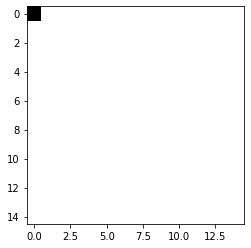

In [25]:
q_modified = q.clone()
# modify top-left corner
# and check that only one position changed in the output
q_modified[:, :, 0, 0] = 5
number_of_differences = torch.isclose(
    attn_windows(q, k, v),
    attn_windows(q_modified, k, v),
)
plt.imshow(
    reduce(number_of_differences.float(), 'b c h w -> h w', 'mean'),
    cmap='gray'
)

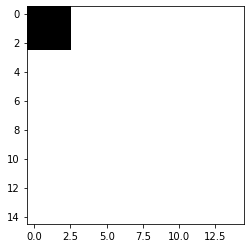

In [26]:
k_modified = k.clone()
# modify top-left corner
# and check that only positions in a window changed
k_modified[:, :, 0, 0] = 5
number_of_differences = torch.isclose(
    attn_windows(q, k, v),
    attn_windows(q, k_modified, v),
)
plt.imshow(
    reduce(number_of_differences.float(), 'b c h w -> h w', 'mean'),
    cmap='gray'
)

## Windowed attention with logit shifts

To provide some information about positions of elements in attention, there are several ways:

1. add a learnable term to logits, cheap and seems to work
2. add position-dependent term to q / k / v or only to q / k; this probably worth adding, but it can be done as well outside of attention module.
3. all kinds of relpos. This group is messy, implementations are hard and frequently resource-hungry specially in some corner cases.
   - I am not convinced this group even worth thinking about - see again CAPE, benefits of relpos are minimal, headache is maximal

So, let's add option 1. to previous method

In [27]:
window_size = 3

attn_windows = EinAttention(
    'b * (Wh h) (Ww w) <- b * (Wh h) (Ww w), b * (Wh h_kv) (Ww w_kv)',
    # which parameters define shift? internally a tensor of this shape is created
    logshift_param="h w h_kv w_kv",
    # now we need to specify all the dimension so that this tensor could be created
    h=window_size, w=window_size, h_kv=window_size, w_kv=window_size,
)

attn_windows(q, k, v).shape

torch.Size([7, 33, 15, 15])

## Strided attention (MaxVit / MobileViT)

In [28]:
stride = 3

attn_strides = EinAttention(
    'b * (Wh h) (Ww w) <- b * (Wh h) (Ww w), b * (Wh_kv h) (Ww_kv w)',
    h=stride, w=stride,
)

print(
    attn_strides(q, k, v).shape
)


torch.Size([7, 33, 15, 15])


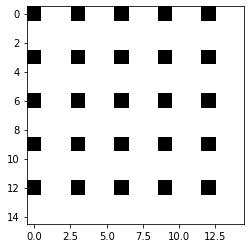

In [29]:
number_of_differences = torch.isclose(
    attn_strides(q, k, v),
    attn_strides(q, k_modified, v),
)
plt.imshow(
    reduce(number_of_differences.float(), 'b c h w -> h w', 'mean'),
    cmap='gray'
)

## Frenzy

let's make an attention layer for video.

- Multi headed, but also with groups of heads.
- strided on time and image dimensions
- unless you have H100 gpu, we can skip batch dimensions.

In [30]:
class CausalVideoAttention(EinAttention):
    def __init__(self, stride: int, time_stride: int, n_heads: int):
        super().__init__(
            '(T t) (head *) (H h) (W w) <- (T t) (head *) (H h) (W w), (T_kv t) (head *) (H_kv h) (W_kv w)',
            h=stride, w=stride, t=time_stride, head=n_heads,
        )

    def modify_logit_inplace(self, logit_all_dims):
        T_q, T_kv = self.get_logit_dimensions_grid(logit_all_dims, ['T', 'T_kv'])
        causal_mask = (T_kv <= T_q)
        logit_all_dims.add_(causal_mask.float().mul(100))

In [31]:
CausalVideoAttention.get_logit_dimensions_grid??

In [32]:
videoatt = CausalVideoAttention(time_stride=3, stride=5, n_heads=2)
x = torch.randn(6 * 3, 2 * 11, 3 * 5, 4 * 5) # lazy, will use a single tensor
videoatt(q=x, k=x, v=x).shape

torch.Size([18, 22, 15, 20])

## Flexible logshift-based learnable relpos for 1d

Built-in logshift_param has limited flexibility: corresponding dimensions should be fixed.



In [33]:
# Suppose we want to introduce a logshift-based learned attention (because we have learnable relpos) to vanilla 1d self-attention

EinAttention('b t_q * <- b t_q *, b t_kv *')

# if we introduce logshift_param like this, it is a full matrix and all sequences passed should be of the same length
# - for most applications that's a no-go.
EinAttention(
    'b t_q (head *) <- b t_q (head *), b t_kv (head *)',
    logshift_param='head t_q t_kv',
    t_q=100, t_kv=100, head=8,
)

Einattention(...)

In [34]:
# So let's implement a custom relshift, again by subclassing
# and defining custom logit modification

class RelPosWithLearnableLogshifts(EinAttention):
    def __init__(self, relpos_length: int, n_heads):
        super().__init__('b t_q (h *) <- b t_q (h *), b t_kv (h *)', h=n_heads)

        self.shifts = torch.nn.Parameter(torch.zeros(n_heads, 2 * relpos_length - 1).float())
        self.relpos_length = relpos_length

    def modify_logit_inplace(self, logit_all_dims):
        head, t_q, t_kv = self.get_logit_dimensions_grid(logit_all_dims, ['h', 't_q', 't_kv'])
        # clip maximal distance. Note that here we rely on negative indexing (this can be changed)
        distance = (t_q - t_kv).clamp(-self.relpos_length, self.relpos_length)

        shifts = self.shifts[head, distance]
        logit_all_dims.add_(shifts)

        # we can additionally mask for causality here if we want.

In [35]:
relpos = RelPosWithLearnableLogshifts(relpos_length=11, n_heads=4)
q, k, v = torch.randn(3, 5, 25, 4 * 3)
relpos(q, k, v).shape

torch.Size([5, 25, 12])